In [11]:
# 1. Install librosa if needed
!pip install librosa --quiet
!pip install xgboost --quiet

# 2. Import libraries
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb


# 3. Define corrected data directories
no_drone_dirs = ['/kaggle/input/audio-data/Train_label_0/Train_label_0','/kaggle/input/actualdrone/Binary_Drone_Audio/unknown','/kaggle/input/background/background']
drone_dirs = ['/kaggle/input/actualdrone/Binary_Drone_Audio/yes_drone','/kaggle/input/audio-data/Train_label_1/Train_label_1','/kaggle/input/finalaudio/newdata']

In [10]:
# 4. Feature extraction function
def extract_mfcc_chroma_contrast(file_path, n_mfcc=13, max_pad_len=130):
    y, sr = librosa.load(file_path, sr=None)
    n_fft = min(2048, len(y))
    
    # MFCC extraction
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    mfcc = librosa.util.fix_length(mfcc, size=max_pad_len, axis=1)

    # Chroma extraction
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft)
    chroma = librosa.util.fix_length(chroma, size=max_pad_len, axis=1)

    # Spectral Contrast extraction with safety
    try:
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft)
        contrast = librosa.util.fix_length(contrast, size=max_pad_len, axis=1)
    except Exception:
        # Default value if calculation fails
        contrast = np.zeros((7, max_pad_len))
    
    features = np.concatenate([mfcc, chroma, contrast], axis=0)
    return features.flatten()

# 5. Load data & extract features (including debug prints)
X, y = [], []
print("No drone sample files:", os.listdir(no_drone_dirs[0])[:3])
print("Drone sample files:", os.listdir(drone_dirs[0])[:3])


No drone sample files: ['102444.wav', '101973.wav', '102537.wav']
Drone sample files: ['mixed_membo_62-membo_002_.wav', 'mixed_membo_46-membo_003_.wav', 'B_S2_D1_084-bebop_001_.wav']


In [12]:
# Non-drone files (label 0)
for d in no_drone_dirs:
    for file_name in os.listdir(d):
        if file_name.lower().endswith('.wav'):
            features = extract_mfcc_chroma_contrast(os.path.join(d, file_name))
            X.append(features)
            y.append(0)

# Drone files (label 1)
for d in drone_dirs:
    for file_name in os.listdir(d):
        if file_name.lower().endswith('.wav'):
            features = extract_mfcc_chroma_contrast(os.path.join(d, file_name))
            X.append(features)
            y.append(1)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape)


Dataset shape: (14761, 4160)


In [13]:
# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# 8. Evaluate model
y_pred = xgb_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Drone", "Drone"]))


Accuracy: 0.9972908906197088
              precision    recall  f1-score   support

    No Drone       1.00      1.00      1.00      2281
       Drone       1.00      0.99      0.99       672

    accuracy                           1.00      2953
   macro avg       1.00      1.00      1.00      2953
weighted avg       1.00      1.00      1.00      2953



Prediction: Drone with confidence 0.5152


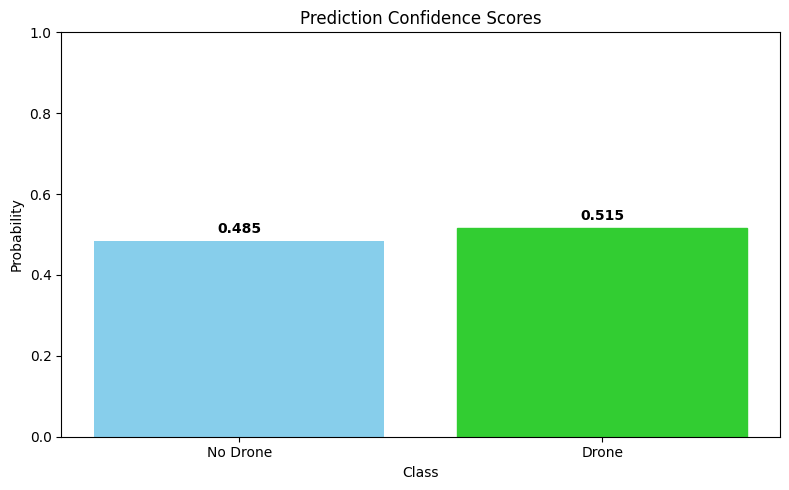


Detailed Results:
Audio file: HELICOPTER_022.wav
No Drone probability: 0.4848
Drone probability: 0.5152
Confidence margin: 0.0303


In [19]:
import matplotlib.pyplot as plt
import numpy as np


new_audio_path ='/kaggle/input/testing/Data/Audio/HELICOPTER_022.wav' 


features = extract_mfcc_chroma_contrast(new_audio_path)  

features = features.reshape(1, -1)


prediction = xgb_clf.predict(features)[0]
probs = xgb_clf.predict_proba(features)[0]   


labels = ["No Drone", "Drone"]
pred_label = labels[prediction]
pred_prob = probs[prediction]
print(f"Prediction: {pred_label} with confidence {pred_prob:.4f}")


plt.figure(figsize=(8, 5))
bars = plt.bar(labels, probs, color=['skyblue', 'salmon'])
plt.ylim(0,1)
plt.title("Prediction Confidence Scores")
plt.ylabel("Probability")
plt.xlabel("Class")

bars[prediction].set_color('limegreen')


for bar, prob in zip(bars, probs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f"{prob:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDetailed Results:")
print(f"Audio file: {new_audio_path.split('/')[-1]}")
print(f"No Drone probability: {probs[0]:.4f}")
print(f"Drone probability: {probs[1]:.4f}")
print(f"Confidence margin: {abs(probs[1] - probs[0]):.4f}")

